In [1]:
import os
import sys

In [2]:
sys.path.insert(0, '/Users/leonshting/Programming/Schlumberger/fem-framework/')

In [3]:
import numpy as np
from interpolant.cell_to_points import Cell2PointsConverter
from interpolant.strict import StrictSolve
from interpolant.opt import OptSolve
from common.helpers import *
from interpolant.helpers import *
from matplotlib import pyplot as plt
%matplotlib inline

In [4]:
c2p = Cell2PointsConverter(orders=[[2],[2,2]])

In [5]:
strict_solve = StrictSolve(points=c2p.get_points(), weights=c2p.get_diag_weights(), verbose=True)

In [6]:
strict_solve.fit_strict(max_power=strict_solve.get_max_pow(unrisky=False), method='sympy')

Number of equations: 8
Number of degrees of freedom: 15
Strictly stitched_power: 0
Start solving strict part
End solving strict part
NullspaceRank: 8


In [7]:
interps = strict_solve.get_interpolants()
wgths = strict_solve.get_weight_matrices()

In [8]:
opt_solve = OptSolve(matrices=interps,
                     points=c2p.get_points(),
                     strict_power=strict_solve.get_max_pow(unrisky=False),
                     weights_matrices=wgths,
                     verbose=True
                    )

In [9]:
opt_solve.fit_opt(constraints=True, tr_fun_option='chebyshev', orders_forwards=2)

In [ ]:
opt_solve.restart_opt(tolerance=1e-3)

In [10]:
I_rl = np.array(opt_solve.I_rl_subbed).astype(np.float64)
I_lr = np.array(opt_solve.I_lr_subbed).astype(np.float64)

In [11]:
tr_f = np.vectorize(lambda x: x**2 + x**3)

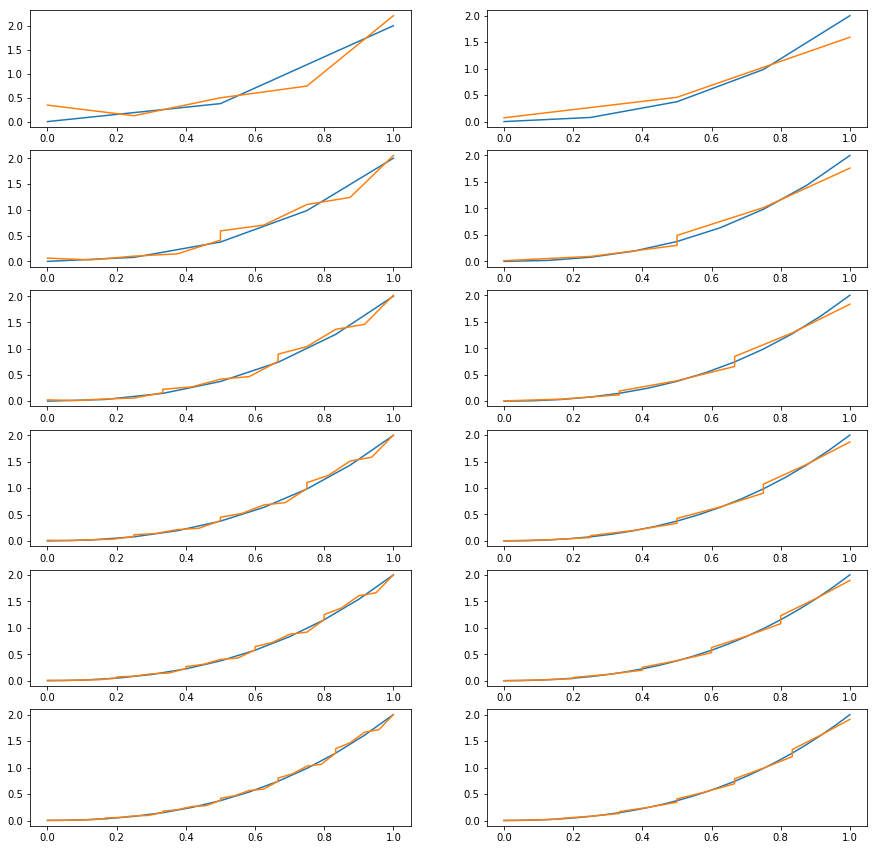

In [12]:
eps_l, eps_r = convergence_test(I_lr=I_lr,
                                I_rl=I_rl,
                                p_l=opt_solve.points[0],
                                p_r=opt_solve.points[1],
                                init_size=(0,1),
                                tr_f=tr_f,
                                weights=[np.array(strict_solve.W_l), np.array(strict_solve.W_r)],
                                div_lim=7)

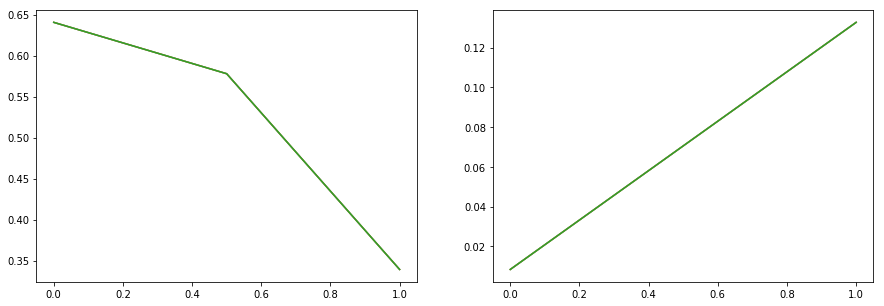

In [23]:
explosion_test(I_lr=I_lr,
               I_rl=I_rl,
               p_l=opt_solve.points[0],
               p_r=opt_solve.points[1],
               tr_f=tr_f,
               reps=3)

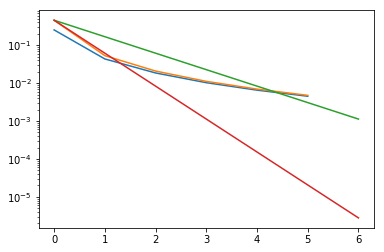

In [24]:
plt.semilogy(range(len(eps_l)), eps_l)
plt.semilogy(range(len(eps_r)), eps_r)
plt.semilogy(np.linspace(0, len(eps_r)), float(eps_r[0])*np.exp(-np.linspace(0, len(eps_r))))
plt.semilogy(np.linspace(0, len(eps_r)), float(eps_r[0])*np.exp(-2*np.linspace(0, len(eps_r))))

In [15]:
np.linalg.eigvals(np.dot(I_lr, I_rl))

array([  6.43479647e-01,   8.93427829e-01,   1.00000000e+00,
        -7.45587838e-17,  -5.00012312e-18])

In [13]:
I_lr

array([[ 0.99607538, -0.20644999,  0.2103746 ],
       [ 0.32912448,  0.75031401, -0.0794385 ],
       [-0.11388202,  1.06570119,  0.04818083],
       [-0.07294125,  0.86437301,  0.20856824],
       [ 0.20695574, -0.38370049,  1.17674476]])

In [14]:
I_rl

array([[ 0.49803769,  0.65824896, -0.11388202, -0.1458825 ,  0.10347787],
       [-0.02580625,  0.37515701,  0.2664253 ,  0.43218651, -0.04796256],
       [ 0.1051873 , -0.15887699,  0.04818083,  0.41713648,  0.58837238]])